In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sentence_transformers import SentenceTransformer
from scipy.spatial.distance import cosine
import os

c:\Users\rahul\.conda\envs\rahul\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [ ]:
df = pd.read_csv(r"C:\Users\rahul\Downloads\combined_songs.csv")

In [ ]:
df['artist_genre']

0                                    arabesk, turkish folk
1                                                 dark r&b
2        album rock, classic rock, dance rock, hard roc...
3                                                 No Genre
4                                                 No Genre
                               ...                        
24979                                 antiviral pop, pixel
24980                                       new york drill
24981                                             No Genre
24982                                             football
24983    rap baixada fluminense, trap brasileiro, trap ...
Name: artist_genre, Length: 24984, dtype: object

In [ ]:
# Replace 'No Genre' with an empty string
df['artist_genre'] = df['artist_genre'].replace('No Genre', '')

# Alternatively, if you want to be more specific:
df.loc[df['artist_genre'] == 'No Genre', 'artist_genre'] = ''

In [ ]:
df['artist_genre']

0                                    arabesk, turkish folk
1                                                 dark r&b
2        album rock, classic rock, dance rock, hard roc...
3                                                         
4                                                         
                               ...                        
24979                                 antiviral pop, pixel
24980                                       new york drill
24981                                                     
24982                                             football
24983    rap baixada fluminense, trap brasileiro, trap ...
Name: artist_genre, Length: 24984, dtype: object

EMBEDDINGS of Genres

In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer

# Initialize the model
model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')

# Combine the genre columns and generate embeddings
def generate_genre_embeddings(genres):
    genre_list = genres.strip('[]').replace("'", "").split(', ')
    combined_genre_text = ' '.join(genre_list)
    return model.encode(combined_genre_text)

# Generate embeddings for the artist genres
df['genre_embeddings'] = df['artist_genre'].apply(generate_genre_embeddings)

# Check if the embeddings are generated correctly
print("Generated embeddings for genres:")
print(df['genre_embeddings'].head())


Generated embeddings for genres:
0    [-0.55334234, 0.11329375, -0.41601044, -0.1349...
1    [-0.25865352, -0.15676247, 0.40406537, -0.6103...
2    [-0.65369993, -0.094492376, 0.5468958, -0.1892...
3    [-0.33302292, 0.40712154, 0.4667511, -0.496053...
4    [-0.33302292, 0.40712154, 0.4667511, -0.496053...
Name: genre_embeddings, dtype: object


In [ ]:
df['genre_embeddings'].shape

(24984,)

CLUSTERING the Genres

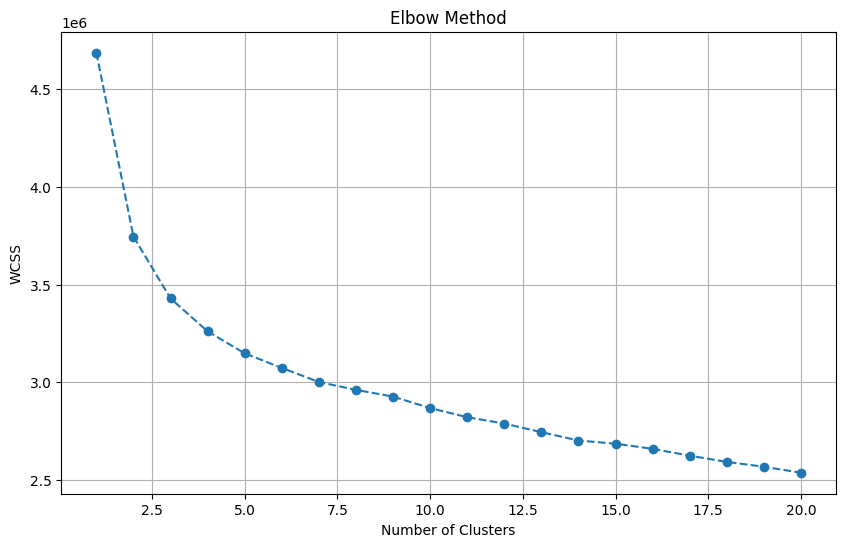

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Convert embeddings to matrix
genre_matrix = np.vstack(df['genre_embeddings'].values)

# Elbow Method to find the optimal number of clusters
def elbow_method(data):
    wcss = []
    for i in range(1, 21):  # Trying 1 to 20 clusters
        kmeans = KMeans(n_clusters=i, random_state=42)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 21), wcss, marker='o', linestyle='--')
    plt.title('Elbow Method')
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS')
    plt.grid()
    plt.show()

# Apply elbow method to genre matrix
elbow_method(genre_matrix)


In [ ]:
from sklearn.metrics import silhouette_score

def silhouette_analysis(data):
    silhouette_scores = []
    for n_clusters in range(2, 21):  # Trying 2 to 20 clusters
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        silhouette_scores.append(silhouette_avg)

    plt.figure(figsize=(10, 6))
    plt.plot(range(2, 21), silhouette_scores, marker='o', linestyle='--')
    plt.title('Silhouette Analysis')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.grid()
    plt.show()

# Apply silhouette analysis to genre matrix
silhouette_analysis(genre_matrix)


MemoryError: Unable to allocate 81.8 MiB for an array with shape (3274, 3274) and data type float64

In [ ]:
from sklearn.cluster import KMeans
# Assuming optimal_n_clusters is determined from the elbow or silhouette method
optimal_n_clusters = 10  # Example value from the analysis

genre_matrix = np.vstack(df['genre_embeddings'].values)

# Perform KMeans clustering
kmeans = KMeans(n_clusters=optimal_n_clusters, random_state=42).fit(genre_matrix)
df['genre_cluster'] = kmeans.labels_

# Check the clustering results
print("Cluster labels assigned to genres:")
print(df[['artist_genre', 'genre_cluster']].head())


Cluster labels assigned to genres:
                                        artist_genre  genre_cluster
0                              arabesk, turkish folk              0
1                                           dark r&b              2
2  album rock, classic rock, dance rock, hard roc...              7
3                                                                 1
4                                                                 1


In [ ]:
df

,song_title,song_id,track_popularity,track_duration,explicit,artist_name,artist_id,artist_genre,album_id,album_type,...,type,id,uri,track_href,analysis_url,duration_ms,time_signature,Lyrics,genre_embeddings,genre_cluster
0,Benim Babam (Bu Adam Benim Babam),7ijRJzpYlw1uyh0kJ6WPJp,35,332022,False,Fatih Kısaparmak,5JiRFs54W65l4k97s66Eef,"arabesk, turkish folk",4mAej5VFJ4hpQg0YoOK593,album,...,audio_features,7ijRJzpYlw1uyh0kJ6WPJp,spotify:track:7ijRJzpYlw1uyh0kJ6WPJp,https://api.spotify.com/v1/tracks/7ijRJzpYlw1u...,https://api.spotify.com/v1/audio-analysis/7ijR...,332022,4,2 ContributorsBu Adam Benim Babam LyricsBu Ada...,"[-0.55334234, 0.11329375, -0.41601044, -0.1349...",0
1,IDONTWANNASTAY,4y0NzIgyQJgNjZGDnmO7KD,39,159051,False,Kaphy,3wigq7ogMWIk2GhsT7BJC5,dark r&b,69NYnMmT4jr1dY94ni1V7Z,single,...,audio_features,4y0NzIgyQJgNjZGDnmO7KD,spotify:track:4y0NzIgyQJgNjZGDnmO7KD,https://api.spotify.com/v1/tracks/4y0NzIgyQJgN...,https://api.spotify.com/v1/audio-analysis/4y0N...,159052,4,1 ContributorIDONTWANNASTAY LyricsI'm tryna un...,"[-0.25865352, -0.15676247, 0.40406537, -0.6103...",2
2,Eyes Without A Face,0pUVeEgZuNyFzIMKp67RbS,76,299240,False,Billy Idol,7lzordPuZEXxwt9aoVZYmG,"album rock, classic rock, dance rock, hard roc...",2FZNWUmgRoP8uJZBaHJdfj,album,...,audio_features,0pUVeEgZuNyFzIMKp67RbS,spotify:track:0pUVeEgZuNyFzIMKp67RbS,https://api.spotify.com/v1/tracks/0pUVeEgZuNyF...,https://api.spotify.com/v1/audio-analysis/0pUV...,299240,4,55 ContributorsEyes Without a Face Lyrics\nI'm...,"[-0.65369993, -0.094492376, 0.5468958, -0.1892...",7
3,From a Logical Point of View,1rw7Ajqh0zjTpo29stGLu4,35,177983,False,Jensen Ackles,539FiNgLTBmfQzYMSTGhbi,,0UmSlRZUatcKfEAIZ7piYA,album,...,audio_features,1rw7Ajqh0zjTpo29stGLu4,spotify:track:1rw7Ajqh0zjTpo29stGLu4,https://api.spotify.com/v1/tracks/1rw7Ajqh0zjT...,https://api.spotify.com/v1/audio-analysis/1rw7...,177984,4,3 ContributorsFrom a Logical Point of View Lyr...,"[-0.33302292, 0.40712154, 0.4667511, -0.496053...",1
4,Gemendo Femininos,4uacHtbD37f4NuBhTD5pfc,2,130701,False,Djjazznobeat,0MhNJyXws2pdpTN1n9vBrW,,0G9LrjU7FgQhWJKivWOAcx,single,...,audio_features,4uacHtbD37f4NuBhTD5pfc,spotify:track:4uacHtbD37f4NuBhTD5pfc,https://api.spotify.com/v1/tracks/4uacHtbD37f4...,https://api.spotify.com/v1/audio-analysis/4uac...,130702,4,Likely instrumental or very low lyrics,"[-0.33302292, 0.40712154, 0.4667511, -0.496053...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24979,Revenge,0z3XcxcrqvWe36Dtgiqrh0,55,220208,False,Captainsparklez,6P9aim24wqJZ3SdoCWYwGT,"antiviral pop, pixel",2rpIKa3fNS6ijq0bu8v32S,single,...,audio_features,0z3XcxcrqvWe36Dtgiqrh0,spotify:track:0z3XcxcrqvWe36Dtgiqrh0,https://api.spotify.com/v1/tracks/0z3XcxcrqvWe...,https://api.spotify.com/v1/audio-analysis/0z3X...,220208,4,240 ContributorsTranslationsDeutschRevenge Lyr...,"[-0.6397123, -0.15474574, -0.117248476, 0.3643...",8
24980,Notti Bop,0IEpFiWXbmfpiiUHPlPkYC,61,225875,True,Kyle Richh,0hF6lbAjRsq4svrQUr5sgU,new york drill,7vkQS7TYsnbF0AopUZ7tjI,single,...,audio_features,0IEpFiWXbmfpiiUHPlPkYC,spotify:track:0IEpFiWXbmfpiiUHPlPkYC,https://api.spotify.com/v1/tracks/0IEpFiWXbmfp...,https://api.spotify.com/v1/audio-analysis/0IEp...,225875,4,"61 ContributorsNotti Bop Lyrics\nLike, 41K, y'...","[-0.07743362, 0.00015758276, -0.5002109, -0.44...",0
24981,Compás de Espera,10mwTAVbf2i7HoMV4xYdDO,20,185906,False,Maria Medina,0cuzLutbpu8OYFWwBh4THg,,7f1DiSnK7Rs1pktvnNJlc5,compilation,...,audio_features,10mwTAVbf2i7HoMV4xYdDO,spotify:track:10mwTAVbf2i7HoMV4xYdDO,https://api.spotify.com/v1/tracks/10mwTAVbf2i7...,https://api.spotify.com/v1/audio-analysis/10mw...,185907,4,2 ContributorsCompás de espera - a dueto con M...,"[-0.33302292, 0.40712154, 0.4667511, -0.496053...",1
24982,UEFA Europa League Anthem,7li2B5ovRTzE42gHvoxN8H,46,41160,False,UEFA,2dams9psI8ss1wZd2l62Xe,football,5JM6fxhx3LYvG1r1DtVlNR,single,...,audio_features,7li2B5ovRTzE42gHvoxN8H,spotify:track:7li2B5ovRTzE42gHvoxN8H,https:

VISUALIZING the Clusters using t-sne

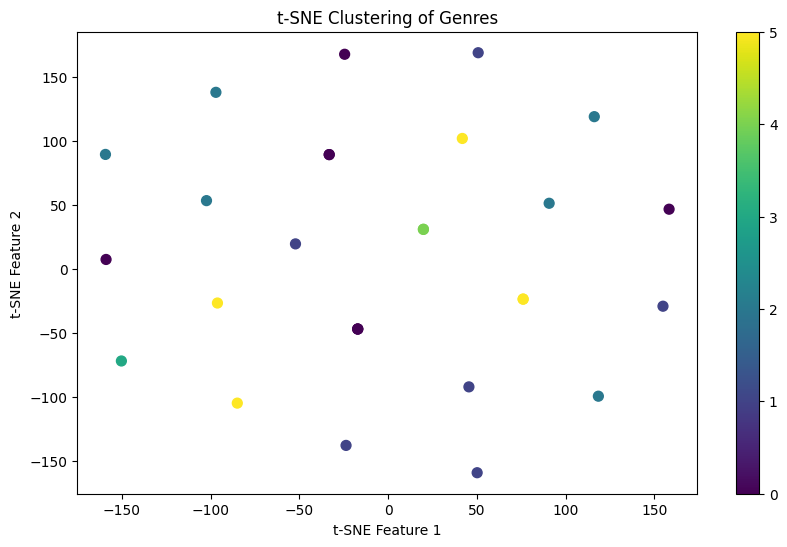

In [ ]:
from sklearn.manifold import TSNE

# Reduce dimensions for visualization
perplexity_value = min(30, genre_matrix.shape[0] - 1)  # Set perplexity to be less than the number of samples
tsne = TSNE(n_components=2, perplexity=perplexity_value, random_state=42)
genre_tsne = tsne.fit_transform(genre_matrix)

# Create a DataFrame for t-SNE results
df_genre_tsne = pd.DataFrame(genre_tsne, columns=['tsne1', 'tsne2'])

# Add the cluster labels for coloring
df_genre_tsne['cluster'] = df['genre_cluster']

# Plot the t-SNE results for genres
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df_genre_tsne['tsne1'], df_genre_tsne['tsne2'], c=df_genre_tsne['cluster'], s=50)
plt.title('t-SNE Clustering of Genres')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.colorbar(scatter)
plt.show()


COSINE SIMILARITY

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

# Assuming 'df' is the DataFrame containing the genre embeddings
# Extract genre embeddings for cosine similarity calculation
genre_embeddings = np.vstack(df['genre_embeddings'].values)

# Calculate cosine similarity matrix
cosine_sim_matrix = cosine_similarity(genre_embeddings)

# Convert cosine similarity to cosine distance
cosine_dist_matrix = 1 - cosine_sim_matrix

# Create a DataFrame for easier interpretation
song_names = df['song_title'].values
cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=song_names, columns=song_names)
cosine_dist_df = pd.DataFrame(cosine_dist_matrix, index=song_names, columns=song_names)

def get_cosine_metrics_by_index(index1, index2):
    if index1 >= len(song_names) or index2 >= len(song_names):
        raise ValueError(f"Indices {index1} and {index2} are out of range")

    song1 = song_names[index1]
    song2 = song_names[index2]

    sim = cosine_sim_df.iloc[index1, index2]
    dist = cosine_dist_df.iloc[index1, index2]
    return song1, song2, sim, dist

# Example usage
index1 = 25
index2 = 27
song1, song2, similarity, distance = get_cosine_metrics_by_index(index1, index2)
print(f"Cosine Similarity between '{song1}' and '{song2}': {similarity}")
print(f"Cosine Distance between '{song1}' and '{song2}': {distance}")

Cosine Similarity between 'MIA (feat. Drake)' and 'Where Red Paints the Ocean': 0.28966856002807617
Cosine Distance between 'MIA (feat. Drake)' and 'Where Red Paints the Ocean': 0.7103314399719238


In [ ]:
index1 = 3
index2 = 24981
song1, song2, similarity, distance = get_cosine_metrics_by_index(index1, index2)
print(f"Cosine Similarity between '{song1}' and '{song2}': {similarity}")
print(f"Cosine Distance between '{song1}' and '{song2}': {distance}")

Cosine Similarity between 'Впереди' and 'Déjenme Si Estoy Llorando - Chuntaro Style': 0.3678781986236572
Cosine Distance between 'Впереди' and 'Déjenme Si Estoy Llorando - Chuntaro Style': 0.6321218013763428


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

def scale_and_calculate_cosine_similarity(genre_embeddings, genre_clusters):
    # Combine genre embeddings and clusters
    combined_features = np.hstack((genre_embeddings, genre_clusters.reshape(-1, 1)))

    # Scale the combined features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(combined_features)

    # Calculate cosine similarity matrix
    cosine_sim_matrix = cosine_similarity(scaled_features)

    # Clip values to ensure they're within the [-1, 1] range
    cosine_sim_matrix = np.clip(cosine_sim_matrix, -1, 1)

    # Convert cosine similarity to cosine distance
    cosine_dist_matrix = 1 - cosine_sim_matrix

    return cosine_sim_matrix, cosine_dist_matrix

def find_top_similar_pairs(similarity_matrix, song_names, top_n=5):
    # Get the upper triangle of the similarity matrix, excluding the diagonal
    upper_triangle_indices = np.triu_indices_from(similarity_matrix, k=1)

    # Get the similarity values from the upper triangle
    similarity_values = similarity_matrix[upper_triangle_indices]

    # Get the sorted indices of the top N similarity values
    sorted_indices = np.argsort(similarity_values)[-top_n:][::-1]

    # Get the corresponding song pairs and their similarity values
    top_pairs = [(song_names[upper_triangle_indices[0][i]],
                  song_names[upper_triangle_indices[1][i]],
                  similarity_values[i]) for i in sorted_indices]

    return top_pairs

# Assuming 'df' is the DataFrame containing the genre embeddings and clusters
genre_embeddings = np.vstack(df['genre_embeddings'].values)
genre_clusters = df['genre_cluster'].values

# Calculate cosine similarity and distance matrices with scaled embeddings and clusters
cosine_sim_matrix, cosine_dist_matrix = scale_and_calculate_cosine_similarity(genre_embeddings, genre_clusters)

# Create DataFrames for easier interpretation
song_names = df['Track Name'].values
cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=song_names, columns=song_names)
cosine_dist_df = pd.DataFrame(cosine_dist_matrix, index=song_names, columns=song_names)

# Get the top 15 similar song pairs
top_similar_pairs = find_top_similar_pairs(cosine_sim_df.values, song_names, top_n=15)

# Print the top similar song pairs
print("Top similar song pairs (after scaling):")
for song1, song2, similarity in top_similar_pairs:
    print(f"'{song1}' and '{song2}' with similarity: {similarity:.6f}")

# Function to get cosine metrics by index
def get_cosine_metrics_by_index(index1, index2):
    if index1 >= len(song_names) or index2 >= len(song_names):
        raise ValueError(f"Indices {index1} and {index2} are out of range")

    song1 = song_names[index1]
    song2 = song_names[index2]

    sim = cosine_sim_df.iloc[index1, index2]
    dist = cosine_dist_df.iloc[index1, index2]
    return song1, song2, sim, dist

# Example usage of get_cosine_metrics_by_index
index1 = 0
index2 = 24
song1, song2, similarity, distance = get_cosine_metrics_by_index(index1, index2)
print(f"\nCosine Similarity between '{song1}' and '{song2}': {similarity:.6f}")
print(f"Cosine Distance between '{song1}' and '{song2}': {distance:.6f}")

Top similar song pairs (after scaling):
'What Jhumka ? (From "Rocky Aur Rani Kii Prem Kahaani")' and 'Ve Kamleya (From "Rocky Aur Rani Kii Prem Kahaani")' with similarity: 1.000000
'Thumkeshwari' and 'Apna Bana Le' with similarity: 1.000000
'Sajni (From "Laapataa Ladies")' and 'Lo Maan Liya' with similarity: 1.000000
'Lo Maan Liya' and 'Roke Na Ruke Naina' with similarity: 1.000000
'Angaaron (From "Pushpa 2 The Rule") [HINDI]' and 'Sajni (From "Laapataa Ladies")' with similarity: 1.000000
'Angaaron (From "Pushpa 2 The Rule") [HINDI]' and 'Satranga (From "ANIMAL")' with similarity: 1.000000
'Satranga (From "ANIMAL")' and 'Roke Na Ruke Naina' with similarity: 1.000000
'Angaaron (From "Pushpa 2 The Rule") [HINDI]' and 'Lo Maan Liya' with similarity: 1.000000
'Satranga (From "ANIMAL")' and 'Lo Maan Liya' with similarity: 1.000000
'Angaaron (From "Pushpa 2 The Rule") [HINDI]' and 'Roke Na Ruke Naina' with similarity: 1.000000
'Sajni (From "Laapataa Ladies")' and 'Satranga (From "ANIMAL")' w

In [ ]:
# genre_emb = pd.DataFrame(genre_embeddings)
# genre_clu = df[genre_clusters]
final_df = df[['genre_embeddings','genre_cluster']]

In [ ]:
final_df

,genre_embeddings,genre_cluster
0,"[-0.55334234, 0.11329375, -0.41601044, -0.1349...",0
1,"[-0.25865352, -0.15676247, 0.40406537, -0.6103...",2
2,"[-0.65369993, -0.094492376, 0.5468958, -0.1892...",7
3,"[-0.33302292, 0.40712154, 0.4667511, -0.496053...",1
4,"[-0.33302292, 0.40712154, 0.4667511, -0.496053...",1
...,...,...
24979,"[-0.6397123, -0.15474574, -0.117248476, 0.3643...",8
24980,"[-0.07743362, 0.00015758276, -0.5002109, -0.44...",0
24981,"[-0.33302292, 0.40712154, 0.4667511, -0.496053...",1
24982,"[0.34175238, 0.3908243, -0.5472705, 0.10310807...",0


In [ ]:
import pandas as pd
import numpy as np

# Assuming final_df is your DataFrame with genre_embeddings and genre_cluster columns
# Create separate columns for each dimension of the genre embeddings
embeddings_df = pd.DataFrame(final_df['genre_embeddings'].tolist(), index=final_df.index)

# Rename the columns to something meaningful (e.g., embedding_0, embedding_1, ..., embedding_n)
embeddings_df.columns = [f'embedding_{i}' for i in range(embeddings_df.shape[1])]

# Concatenate the embeddings DataFrame with the original final_df (excluding the original genre_embeddings column)
final_df = pd.concat([final_df.drop(columns=['genre_embeddings']), embeddings_df], axis=1)

In [ ]:
final_df

,genre_cluster,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,...,embedding_758,embedding_759,embedding_760,embedding_761,embedding_762,embedding_763,embedding_764,embedding_765,embedding_766,embedding_767
0,0,-0.553342,0.113294,-0.416010,-0.134962,0.269294,-0.400239,0.541727,-0.522865,-0.140981,...,-0.269929,-0.769425,-0.566728,0.246715,-0.738492,-0.494318,0.857649,-0.543620,0.240164,0.233090
1,2,-0.258654,-0.156762,0.404065,-0.610356,0.635011,-0.003464,0.259972,-1.107703,-0.517552,...,-0.803387,0.218310,-0.657758,1.350843,0.354947,-0.332491,0.246031,-0.433288,-0.930692,-0.758862
2,7,-0.653700,-0.094492,0.546896,-0.189279,0.403366,-0.620992,0.139423,-1.317524,0.933088,...,0.081669,-0.853160,-0.127159,0.360682,0.083974,0.028061,0.001613,0.158984,-0.759543,-0.372571
3,1,-0.333023,0.407122,0.466751,-0.496054,-0.088205,-0.066932,0.415361,0.417158,-0.856062,...,-0.028817,-0.064117,0.413059,0.109415,-0.155462,-0.719055,0.027393,-0.249268,-0.543304,0.512378
4,1,-0.333023,0.407122,0.466751,-0.496054,-0.088205,-0.066932,0.415361,0.417158,-0.856062,...,-0.028817,-0.064117,0.413059,0.109415,-0.155462,-0.719055,0.027393,-0.249268,-0.543304,0.512378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24979,8,-0.639712,-0.154746,-0.117248,0.364321,-0.278307,0.310866,0.715002,0.583059,0.276339,...,-0.709065,0.169645,-0.224571,0.581988,0.908267,0.551648,0.728033,0.220461,0.208484,0.671913
24980,0,-0.077434,0.000158,-0.500211,-0.445755,0.082789,-0.845974,0.548288,0.175141,-0.184334,...,-0.320260,-0.777626,-0.058402,-0.617231,-0.305189,-1.165605,0.081666,0.336918,-0.185776,0.062926
24981,1,-0.333023,0.407122,0.466751,-0.496054,-0.088205,-0.066932,0.415361,0.417158,-0.856062,...,-0.028817,-0.064117,0.413059,0.109415,-0.155462,-0.719055,0.027393,-0.249268,-0.543304,0.512378
24982,0,0.341752,0.390824,-0.547270,0.103108,-0.945901,0.066115,0.312204,0.411560,0.100249,...,-0.160834,1.230638,-0.294380,0.235069,-0.047024,-0.098791,0.400835,-0.698870,-0.191246,0.346299


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
cols = [col for col in final_df.columns if col.startswith('embedding_')]
print(cols)
final_df[cols] = scaler.fit_transform(final_df[cols])

['embedding_0', 'embedding_1', 'embedding_2', 'embedding_3', 'embedding_4', 'embedding_5', 'embedding_6', 'embedding_7', 'embedding_8', 'embedding_9', 'embedding_10', 'embedding_11', 'embedding_12', 'embedding_13', 'embedding_14', 'embedding_15', 'embedding_16', 'embedding_17', 'embedding_18', 'embedding_19', 'embedding_20', 'embedding_21', 'embedding_22', 'embedding_23', 'embedding_24', 'embedding_25', 'embedding_26', 'embedding_27', 'embedding_28', 'embedding_29', 'embedding_30', 'embedding_31', 'embedding_32', 'embedding_33', 'embedding_34', 'embedding_35', 'embedding_36', 'embedding_37', 'embedding_38', 'embedding_39', 'embedding_40', 'embedding_41', 'embedding_42', 'embedding_43', 'embedding_44', 'embedding_45', 'embedding_46', 'embedding_47', 'embedding_48', 'embedding_49', 'embedding_50', 'embedding_51', 'embedding_52', 'embedding_53', 'embedding_54', 'embedding_55', 'embedding_56', 'embedding_57', 'embedding_58', 'embedding_59', 'embedding_60', 'embedding_61', 'embedding_62', '

In [ ]:
final_df

,genre_cluster,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,...,embedding_758,embedding_759,embedding_760,embedding_761,embedding_762,embedding_763,embedding_764,embedding_765,embedding_766,embedding_767
0,0,-0.559658,0.078598,-1.411476,0.317114,0.299750,-0.703917,0.048431,-0.295944,-0.167741,...,-0.253995,-0.919566,-0.836808,-0.288809,-2.088184,-0.690731,1.984316,-1.456049,1.126144,0.286425
1,2,0.071337,-0.671710,0.592621,-0.874156,1.078763,0.330534,-0.706646,-1.199230,-0.746443,...,-1.453122,0.966463,-1.027020,1.410087,0.975608,-0.409537,0.471199,-1.220358,-1.602603,-1.326023
2,7,-0.774547,-0.498703,0.941670,0.181002,0.585337,-1.279452,-1.029706,-1.523300,1.482859,...,0.536340,-1.079453,0.081693,-0.113450,0.216350,0.216963,-0.133482,0.044850,-1.203731,-0.698096
3,1,-0.087904,0.894951,0.745812,-0.587731,-0.461757,0.165065,-0.290217,1.155927,-1.266657,...,0.287984,0.427184,1.210508,-0.500069,-0.454545,-1.081239,-0.069704,-0.827256,-0.699773,0.740415
4,1,-0.087904,0.894951,0.745812,-0.587731,-0.461757,0.165065,-0.290217,1.155927,-1.266657,...,0.287984,0.427184,1.210508,-0.500069,-0.454545,-1.081239,-0.069704,-0.827256,-0.699773,0.740415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24979,8,-0.744596,-0.666107,-0.681363,1.568247,-0.866692,1.150038,0.512794,1.412163,0.473586,...,-1.241101,0.873541,-0.121854,0.227068,2.526002,1.126759,1.663650,0.176178,1.052313,0.999744
24980,0,0.459370,-0.235733,-1.617245,-0.461688,-0.097524,-1.866013,0.066015,0.782130,-0.234363,...,-0.367131,-0.935225,0.225364,-1.618142,-0.874078,-1.857174,0.064566,0.424953,0.133465,0.009819
24981,1,-0.087904,0.894951,0.745812,-0.587731,-0.461757,0.165065,-0.290217,1.155927,-1.266657,...,0.287984,0.427184,1.210508,-0.500069,-0.454545,-1.081239,-0.069704,-0.827256,-0.699773,0.740415
24982,0,1.356943,0.849672,-1.732249,0.913683,-2.288731,0.511937,-0.566667,1.147281,0.202975,...,-0.008767,2.899452,-0.267723,-0.306728,-0.150703,-0.003456,0.854176,-1.787693,0.120718,0.470449


In [ ]:
audio_dir = r"C:\Users\rahul\Downloads"
output_csv_final = os.path.join(audio_dir, '25kgenre.csv')
final_df.to_csv(output_csv_final, index=False)
print(f"Final combined features saved to {output_csv_final}")

Final combined features saved to C:\Users\rahul\Downloads\25kgenre.csv


In [ ]:
import pandas as pd
from sklearn.decomposition import PCA

# Assuming final_df is your DataFrame with embedding columns and genre_cluster column
# Extract only the embedding columns
embedding_columns = [col for col in final_df.columns if col.startswith('embedding_')]
embedding_matrix = final_df[embedding_columns].values

# Apply PCA to the embedding matrix
pca = PCA(n_components=0.95)  # Retain 95% of the variance
pca_result = pca.fit_transform(embedding_matrix)

# Create a DataFrame for the PCA results
pca_columns = [f'pca_{i}' for i in range(pca_result.shape[1])]
pca_df = pd.DataFrame(pca_result, columns=pca_columns, index=final_df.index)

# Concatenate the PCA results with the original DataFrame excluding the original embedding columns
final_df = pd.concat([final_df.drop(columns=embedding_columns), pca_df], axis=1)

# Display the updated DataFrame
print(final_df)

audio_dir = r"C:\Users\rahul\Downloads\Songdownloads\Hindi"
output_csv_final = os.path.join(audio_dir, 'final_genre_features.csv')
final_df.to_csv(output_csv_final, index=False)
print(f"Final combined features saved to {output_csv_final}")

    genre_cluster     pca_0      pca_1     pca_2      pca_3     pca_4  \
0               0  7.168178  -0.292603 -0.577788  -2.163383  1.803770   
1               2 -3.236234  -1.537244  2.052166  -0.280372 -3.889902   
2               5  2.473953  -0.739028  0.150895   3.257296 -3.828665   
3               5  5.696177  -0.891970  1.964893   4.147807 -3.648185   
4               0  8.681083   0.924400 -0.850349  -1.543731  1.590261   
5               0  8.681083   0.924400 -0.850347  -1.543731  1.590262   
6               0  8.681083   0.924399 -0.850347  -1.543732  1.590260   
7               5  5.696177  -0.891972  1.964892   4.147807 -3.648183   
8               5  5.723640  -0.162830 -0.281103   0.974496 -2.339465   
9               0  8.681084   0.924399 -0.850348  -1.543731  1.590262   
10              0  7.810430   1.366815  0.984451  -0.215218  0.715716   
11              5  3.160403  -0.887417 -0.361624   0.779294 -1.437011   
12              0  7.168178  -0.292603 -0.577788  -